"""
 - data from https://www.kaggle.com/c/indoor-location-navigation
 - data conversion using main_interp_wtime.py based on time of the wifi recordings 
 - these area every 2.2-2.5 seconds, and their position is intyerpolated linearily assuming constant speed between waypoints 
 - BLE beacons are attached to the closes interpolated point 
 - actual waypoint in the data ay not appear in the json produced
"""

indoor_comp_import.png - example of resulted points (blue) 


In [1]:
from utils import *
import sys, os, random

datadir = "../data.upb/uji/"


In [2]:
uji3_fnames=[
"01/3.0uji_month01_trn01.json",
"01/3.0uji_month01_trn02.json",
"01/3.0uji_month01_trn03.json",
"01/3.0uji_month01_trn04.json",
"01/3.0uji_month01_trn05.json",
"01/3.0uji_month01_trn06.json",
"01/3.0uji_month01_trn07.json",
"01/3.0uji_month01_trn08.json",
"01/3.0uji_month01_trn09.json",
"01/3.0uji_month01_trn10.json",
"01/3.0uji_month01_trn11.json",
"01/3.0uji_month01_trn12.json",
"01/3.0uji_month01_trn13.json",
"01/3.0uji_month01_trn14.json",
"01/3.0uji_month01_trn15.json",
"02/3.0uji_month02_trn01.json",
"03/3.0uji_month03_trn01.json",
"04/3.0uji_month04_trn01.json",
"05/3.0uji_month05_trn01.json",
"06/3.0uji_month06_trn01.json",
"07/3.0uji_month07_trn01.json",
"08/3.0uji_month08_trn01.json",
"09/3.0uji_month09_trn01.json",
"10/3.0uji_month10_trn01.json",
"11/3.0uji_month11_trn01.json"]
uji3_fnames2=[
"12/3.0uji_month12_trn01.json",
"13/3.0uji_month13_trn01.json",
"14/3.0uji_month14_trn01.json",
"15/3.0uji_month15_trn01.json",
"16/3.0uji_month16_trn01.json",
"17/3.0uji_month17_trn01.json",
"18/3.0uji_month18_trn01.json",
"19/3.0uji_month19_trn01.json",
"20/3.0uji_month20_trn01.json",
"21/3.0uji_month21_trn01.json",
"22/3.0uji_month22_trn01.json",
"23/3.0uji_month23_trn01.json",
"24/3.0uji_month24_trn01.json",
"25/3.0uji_month25_trn01.json",
"25/3.0uji_month25_trn02.json"
]

uji5_fnames=[
"01/5.0uji_month01_trn01.json",
"01/5.0uji_month01_trn02.json",
"01/5.0uji_month01_trn03.json",
"01/5.0uji_month01_trn04.json",
"01/5.0uji_month01_trn05.json",
"01/5.0uji_month01_trn06.json",
"01/5.0uji_month01_trn07.json",
"01/5.0uji_month01_trn08.json",
"01/5.0uji_month01_trn09.json",
"01/5.0uji_month01_trn10.json",
"01/5.0uji_month01_trn11.json",
"01/5.0uji_month01_trn12.json",
"01/5.0uji_month01_trn13.json",
"01/5.0uji_month01_trn14.json",
"01/5.0uji_month01_trn15.json",
"02/5.0uji_month02_trn01.json",
"03/5.0uji_month03_trn01.json",
"04/5.0uji_month04_trn01.json",
"05/5.0uji_month05_trn01.json",
"06/5.0uji_month06_trn01.json",
"07/5.0uji_month07_trn01.json",
"08/5.0uji_month08_trn01.json",
"09/5.0uji_month09_trn01.json",
"10/5.0uji_month10_trn01.json",
"11/5.0uji_month11_trn01.json",
"12/5.0uji_month12_trn01.json",
"13/5.0uji_month13_trn01.json",
"14/5.0uji_month14_trn01.json",
"15/5.0uji_month15_trn01.json",
"16/5.0uji_month16_trn01.json",
"17/5.0uji_month17_trn01.json",
"18/5.0uji_month18_trn01.json",
"19/5.0uji_month19_trn01.json",
"20/5.0uji_month20_trn01.json",
"21/5.0uji_month21_trn01.json",
"22/5.0uji_month22_trn01.json",
"23/5.0uji_month23_trn01.json",
"24/5.0uji_month24_trn01.json",
"25/5.0uji_month25_trn01.json",
"25/5.0uji_month25_trn02.json"
]

In [22]:

uji3 = []
for e in uji3_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    uji3.append(etaj)

uji5 = []
for e in uji5_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    uji5.append(etaj)

for e in uji3:
    for c in e:
        precalculate(c)
for e in uji5:
    for c in e:
        precalculate(c)
        
cntw = []
for r in uji3:
    for p in range(0, len(r)): 
        cntw.append(len(r[p]['ufingerprint']['wifirssi'].keys()))
print("APs per point = ", np.percentile(cntw, [50, 95]))        
print(f"uji3 = {len(uji3)} uji5 = {len(uji5)}")        
    

APs per point =  [25. 45.]
uji3 = 25 uji5 = 40


In [31]:
import numpy as np
from scipy.spatial.distance import braycurtis
from scipy.stats import ks_2samp, chisquare
import copy 
import re


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
        d = re.split("[ \-\:]", f['timestamp'])
        ufingerprint['timestamp'] = int(d[5]) + 60*int(d[4]) + 3600*int(d[3]) \
                     +24*3600*int(d[0]) +30*24*3600*int(d[1]) + 12*30*24*3600*(int(d[2])-2016) 
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
    
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    return simil_method(rssi1, rssi2)



In [32]:


def merge_wifi_fingerprints(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def collections_merge(c1, c2):
    assert(c1['x'] == c2['x'] and c1['y'] == c2['y'] and c1['z'] == c2['z'] )
    c = dict()
    c['fingerprints'] = [merge_wifi_fingerprints([c1['fingerprints'][0], c2['fingerprints'][0]])]
    c['x'] = c1['x'] 
    c['y'] = c1['y'] 
    c['z'] = c1['z'] 
    return c

def uji_merge_48(ujisets):
    new_uji = []
    for s in ujisets:
        new_set = []
        for i in range(0, 24):
            new_c = collections_merge(s[i], s[47-i])
            precalculate(new_c)
            new_set.append(new_c)
        new_uji.append(new_set)
    return new_uji

uji3_24 = uji_merge_48(uji3)
#uji5_24 = uji_merge_48(uji5)

cntw = []
for r in uji3_24:
    for p in range(0, len(r)): 
        cntw.append(len(r[p]['ufingerprint']['wifirssi'].keys()))
print("APs per point = ", np.percentile(cntw, [50, 95]))        
print(f"uji3 = {len(uji3_24)} uji5 = ??")        

#print(f"\nc={uji3_24[24][0]}")




APs per point =  [36. 52.]
uji3 = 25 uji5 = ??


In [6]:
# test  points 3-20 in a set vs all points in that set (same time) 

before = datetime.datetime.now()
bd = []

print ("uji3 = ", len(uji3_24))

for r in uji3_24:
    for point in range(3, len(r)-3): 
        for p in range(0, len(r)):
            #if p == point: 
            #    continue 
            eu_dist = euclidean([r[point]['x'], r[point]['y'], r[point]['z']], 
                                    [r[p]['x'], r[p]['y'], r[p]['z']]) 
            if eu_dist < 15.0: 
                bd.append([ point, p, eu_dist, 
                    compare_locations(r[point], r[p], dif=False)])

after = datetime.datetime.now()
print(f"{len(bd)} pairs in {(after-before).seconds} seconds")
# bd contains pi, pj, dist, disimilarity for all pairs in the same set

uji3 =  25
10800 pairs in 4 seconds


In [7]:

# test point 11 along time 

points = range(3, len(uji3_24[0])-3) # same point [3..21] is tested at different times   
before = datetime.datetime.now()
td = []
similarities=np.zeros([len(uji3_24), len(uji3_24)])
for q in range(0, len(uji3_24)):
    for r in range(0, len(uji3_24)):
        if r > q:
            for p in points:  
                #print(r, uji3[r][p]['fingerprints'][0]['timestamp'])
                eu_dist = euclidean([uji3_24[r][p]['x'], uji3_24[r][p]['y'], uji3_24[r][p]['z']], 
                                        [uji3_24[q][p]['x'], uji3_24[q][p]['y'], uji3_24[q][p]['z']]) 
                disim = compare_locations(uji3_24[r][p], uji3_24[q][p], dif=True)
                td.append([ eu_dist, disim])
                similarities[q, r] = disim; 
                similarities[r, q] = disim; 

print(f"Sum of euclidean distances between points in {len(td)} pairs= {np.sum([r[0] for r in td]):.2f}")
td = [r[1] for r in td]
print(f"Disimilarity: mean={np.mean(td):.2f} 5/50/95={np.percentile(td, [5, 50, 95])}")


Sum of euclidean distances between points in 5400 pairs= 0.00
Disimilarity: mean=0.32 5/50/95=[0.13506155 0.30477393 0.54925978]


Slope = [0.05301662 0.17913124] Approximate error from time fitted into distance=2.37m


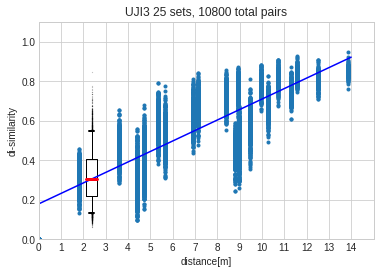

In [8]:
plt.style.use("seaborn-whitegrid")   
#fig, ax =  plt.figure(figsize=(12, 8))  
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot( [r[2] for r in bd], [r[3] for r in bd], ".", label='uji3')


m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
# from disimilarity obtained from comparisons across time(td), 
# we compute the error in euclidean distance that would fit the distance-disimilarity trend 
err_dist_fit = (np.median(td) - m[1])/m[0]
print(f"Slope = {m} Approximate error from time fitted into distance={err_dist_fit:.2f}m")

rbp = ax.boxplot([td],
            positions=[err_dist_fit], 
            whis=(5,95),widths=0.5, 
            flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
            whiskerprops=dict(color='k', linestyle='-'), 
            capprops = dict(color='k', linewidth=2),
            medianprops = dict(color='#ff0011', linewidth=3)
    )
predict = np.poly1d(m)
x_lin_reg = range(0, 15)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')
   
plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"UJI3 {len(uji3_24)} sets, {len(bd)} total pairs")
plt.xticks(range(0, 15), range(0, 15))
plt.xlim(0, 15)
plt.ylim(0, 1.1)
#plt.yticks(np.arange(0, 1.1, 0.1))
#plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"disimilarity_vs_dist_time.pdf", bbox_inches='tight')

In [10]:
def test_queryvsall(query, collections, dif=False):
    """
    query = collection, an array or fingerprints 
    collections = aray of collection, can be a floor  
    RETURNS (similarity, index, eu_distance)
    """
    min = 1000.0 
    mini = -1; 
    for c in range(0, len(collections)):
        d = compare_locations(query, collections[c], braycurtis, dif=dif)
        if d != 0 and d < min:
            min = d 
            mini = c
    return min,mini, \
            euclidean([query['x'], query['y'], query['z']],\
                       [collections[mini]['x'], collections[mini]['y'],collections[mini]['z']])

  

In [11]:
# searches point from set st in other sets 
cl_sim = []
cl_dist = []

for q in range(0, len(uji3_24)): # query set 
    for s in range(0, len(uji3_24)): # testing sets 
        if s == q:
            continue
        for p in range(3, len(uji3_24[q])-3): # each point in query sets 
            sim, index, d =  test_queryvsall(uji3_24[q][p], uji3_24[s], False)
            cl_sim.append(sim)
            cl_dist.append(d)

print(np.percentile(cl_dist, [50, 95, 99]))


[0.         4.38953999 4.73976557]


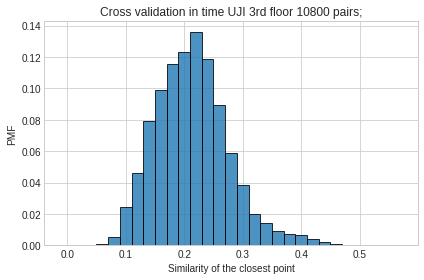

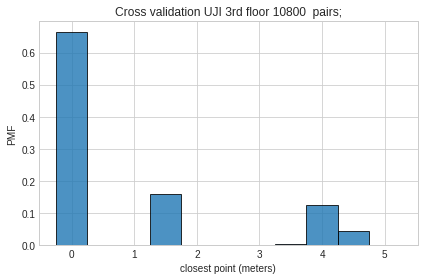

In [12]:
if True:
    b = np.arange(0, 0.6, 0.02) # Bins of histogram - from 1 to 5 
    bin_width = b[1] - b[0]
    hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
    hist_sim = hist_sim / len(cl_sim)
    plt.style.use("seaborn-whitegrid")   
    fig = plt.figure(figsize=(6, 4))
    plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
    plt.xlabel("Similarity of the closest point")
    plt.ylabel("PMF")
    plt.title("{} {}{}".format("Cross validation in time UJI 3rd floor", len(cl_sim), " pairs;"))
    plt.tight_layout()
    plt.show()
    fig.savefig(f"disim-closest-UJI3-time.pdf", bbox_inches='tight')
    #    print("Percentages: ", hist_away)

b = np.arange(0, 6, 0.5) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_dist), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure(figsize=(6, 4))
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (meters)")
plt.ylabel("PMF")
plt.title("{} {} {}".format("Cross validation UJI 3rd floor", len(cl_dist), " pairs;"))
plt.tight_layout()
plt.show()
fig.savefig(f"dist-closest-UJI3-time.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)


No handles with labels found to put in legend.


TOTAL number of APs for each collection spot [87, 77, 76, 83, 64, 75, 79, 65, 65, 75, 62, 63, 77, 70, 74, 77, 62, 75, 77, 61, 69, 73, 65, 83] ++ [87, 77, 76, 83, 64, 75, 79, 65, 65, 75, 62, 63, 77, 70, 74, 77, 62, 75, 77, 61, 69, 73, 65, 83]
[62.3 74.5 81.8]
[0.0, 0.8049999999999784, 4.867800925925934, 5.6822222222222365, 13.72657407407408, 14.101388888888891, 14.713599537037027, 15.057812499999983, 17.768125000000026, 17.89604166666666, 18.018206018518526, 18.14151620370373, 19.076145833333356, 19.93763888888887, 20.173495370370375, 41.85572916666669, 101.08259259259256, 110.13505787037036, 136.06053240740738, 171.0828125, 191.82729166666667, 225.9736342592593, 254.78649305555558, 284.7509027777778, 318.0678009259259]


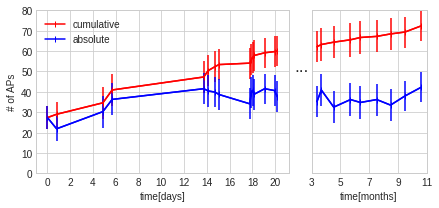

In [147]:
# compute number of APs in time 


# cumulative aps 
#cnaps[s][p] = cumulative number of APs visible at point p at all times [0..s]
#naps[s][p] = number of APs visible at that time 
#tcaps[p] = actual set of APS cumulated for that point 
#tcnaps = # of APs cumulated for each point -- same as count(tcaps[23, :])
tcaps = [set([]) for q in range(0, len(uji3_24[0]))]
cnaps = []
naps = []
for s in range(0, len(uji3_24)):
    cnaps.append([])
    naps.append([])
    for p in range(0, len(uji3_24[s])):
        cnaps[s].append(0)
        naps[s].append(0)
        
for s in range(0, len(uji3_24)):
    for p in range(0, len(uji3_24[s])):
        tcaps[p] = tcaps[p] | set(uji3_24[s][p]['ufingerprint']['wifirssi'].keys()) 
        naps[s][p] = len(uji3_24[s][p]['ufingerprint']['wifirssi'].keys()) 
        cnaps[s][p] = len(tcaps[p])

tcnaps = cnaps[24] 
#print("naps=", naps)

for s in range(0, len(uji3_24)):
    for p in range(0, len(uji3_24[s])):
        naps1 = len(uji3_24[s][p]['ufingerprint']['wifirssi'].keys()) 
        #print(f"{s}-{p} = {naps/allaps[p]:.2f}\n")   
print("TOTAL number of APs for each collection spot", allaps, "++", tcnaps)
print(np.percentile(allaps, [10, 50, 90]))



times = [s[0]['ufingerprint']['timestamp']/3600/24 for s in uji3_24]
times = [s - times[0] for s in times]
print(times)


fig = plt.figure(figsize=(7, 3))
plt.tight_layout()
#plt.subplot(1, 2, 1)
plt.subplot2grid((1,3), (0,0), colspan=2)
plt.ylim(0, 80)
plt.ylabel('# of APs')
for p in range(0, len(uji3_24[0])):
    aps0 = [cnaps[t][p] for t in range(0, 15)] 
    #plt.plot([t-182.0 for t in times[0:15]], aps0, c = 'b')
cnapsmean = []
cnapsstd = []
napsmean = []
napsstd = []
for t in range(0, 15):
    cnapsmean.append(np.mean([cnaps[t][p] for p in range(0, len(uji3_24[0]))])) 
    cnapsstd.append(np.std([cnaps[t][p] for p in range(0, len(uji3_24[0]))])) 
    napsmean.append(np.mean([naps[t][p] for p in range(0, len(uji3_24[0]))])) 
    napsstd.append(np.std([naps[t][p] for p in range(0, len(uji3_24[0]))])) 
plt.plot([ t for t in times[0:15]], cnapsmean, '-|', c = 'r')    
plt.errorbar([ t for t in times[0:15]], cnapsmean, cnapsstd, c = 'r')    
plt.plot([ t for t in times[0:15]], napsmean, '-|', c = 'b')    
plt.errorbar([ t for t in times[0:15]], napsmean, cnapsstd, c = 'b')    
    
plt.xlabel('time[days]')

plt.xticks(range(0, 21, 2))
plt.legend(['cumulative', 'absolute'], loc="upper left",shadow=True, fancybox=True)

#plt.subplot(1, 2, 2)
plt.subplot2grid((1,3), (0,2))
#fig = plt.figure(figsize=(4, 4))
for p in range(0, len(uji3_24[0])):
    aps0 = [cnaps[t][p] for t in range(16, 25)]
    #plt.plot([ (t-182.0)/30 for t in times[16:25]], aps0, '-|', c = 'b')
cnapsmean = []
cnapsstd = []
napsmean = []
napsstd = []
for t in range(16, 25):
    cnapsmean.append(np.mean([cnaps[t][p] for p in range(0, len(uji3_24[0]))])) 
    cnapsstd.append(np.std([cnaps[t][p] for p in range(0, len(uji3_24[0]))])) 
    napsmean.append(np.mean([naps[t][p] for p in range(0, len(uji3_24[0]))])) 
    napsstd.append(np.std([naps[t][p] for p in range(0, len(uji3_24[0]))])) 
plt.plot([ t/30 for t in times[16:25]], cnapsmean, '-|', c = 'r')    
plt.errorbar([ t/30 for t in times[16:25]], cnapsmean, cnapsstd, c = 'r')    
plt.plot([ t/30 for t in times[16:25]], napsmean, '-|', c = 'b')    
plt.errorbar([ t/30 for t in times[16:25]], napsmean, cnapsstd, c = 'b')    

plt.xlabel('time[months]')    
plt.ylim(0, 80)
plt.xticks(range(3, 12, 2))
plt.tick_params(labelleft=False)
plt.grid(True)
#plt.title(f"UJI3 {len(uji3_24)} sets, {len(bd)} total pairs")
#plt.xticks(range(0, 15), range(0, 15))
#plt.xlim(0, 15)
plt.text(1.8,50,'...', fontsize='xx-large')

plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"UJI3-time-number-APs.pdf", bbox_inches='tight')



In [ ]:
# map pairwise distances with MDS 
# visualise clusters in 2D 

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=13, 
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_


news = euclidean_distances(pos)

print(f"fit = {np.percentile(news - similarities, [50, 95])}, pos size={np.size(pos, 0)}")

fig = plt.figure(figsize=(12, 8))
plt.grid(True)
#ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
#plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.show()
